In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

In [2]:
file_path = "C:/Users/afili/Desktop/Uni/Mestrado/AASE/apartments_for_rent_10k_final.csv"
data_fixed = pd.read_csv(file_path, sep=';', on_bad_lines='skip', encoding='utf-8')

In [3]:
# 2. Definir as colunas que deseja verificar por outliers
numerical_features = ['price', 'square_feet', 'bathrooms', 'bedrooms']

# 3. Função para remover outliers usando IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtrar dados dentro dos limites
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# 4. Aplicar a função para remover outliers
data_cleaned = remove_outliers(data_fixed, numerical_features)

# 5. Verificar o tamanho do dataset após remoção
print(f"Tamanho original do dataset: {data_fixed.shape}")
print(f"Tamanho após remoção de outliers: {data_cleaned.shape}")

Tamanho original do dataset: (9994, 53)
Tamanho após remoção de outliers: (8546, 53)


In [4]:
# Select relevant columns
features_valid = [
    'bathrooms', 'bedrooms', 'square_feet', 'AC', 'Alarm', 'Basketball',
    'Cable or Satellite', 'Clubhouse', 'Dishwasher', 'Doorman', 'Elevator',
    'Fireplace', 'Garbage Disposal', 'Gated', 'Golf', 'Gym', 'Hot Tub',
    'Internet Access', 'Luxury', 'Parking', 'Patio/Deck', 'Playground',
    'Pool', 'Refrigerator', 'Storage', 'TV', 'Tennis', 'View', 'Washer Dryer',
    'Wood Floors', 'price'
]
data_relevant = data_cleaned[features_valid].apply(pd.to_numeric, errors='coerce').dropna()

In [5]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_relevant)

In [6]:
# Apply clustering with 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=42)
data_relevant['cluster'] = kmeans_2.fit_predict(data_scaled)

In [8]:
# Extrair os rótulos diretamente
labels_2 = kmeans_2.fit_predict(data_scaled)

# Alternativamente, caso já tenha a coluna no DataFrame:
labels_2 = data_relevant['cluster'].values


In [9]:
# Evaluate the 2-cluster model
silhouette_2 = silhouette_score(data_scaled, labels_2)
davies_2 = davies_bouldin_score(data_scaled, labels_2)

In [10]:
# Plot Elbow Method
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

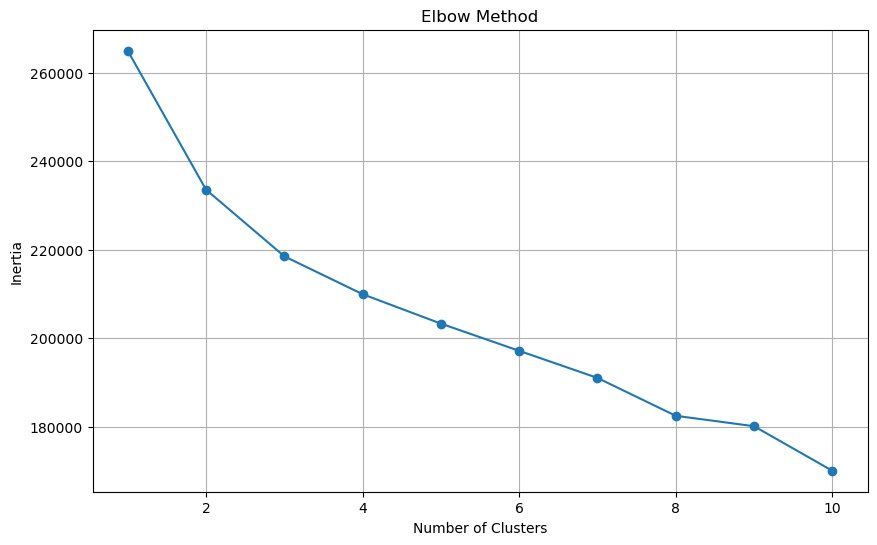

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [12]:
# Plot clusters for 2-cluster model (first two principal components)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

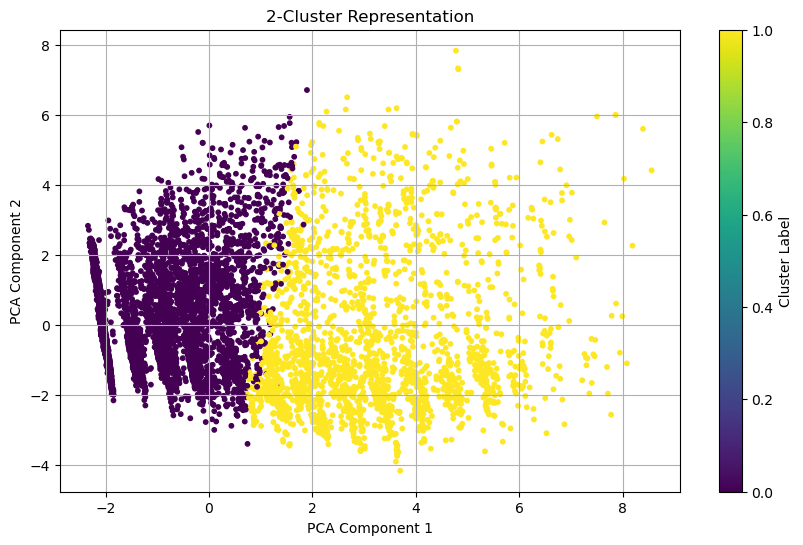

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels_2, cmap='viridis', s=10)
plt.title('2-Cluster Representation')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()


In [14]:
print(f"Silhouette Score for 2 Clusters: {silhouette_2}")
print(f"Davies-Bouldin Index for 2 Clusters: {davies_2}")

Silhouette Score for 2 Clusters: 0.28776506662714757
Davies-Bouldin Index for 2 Clusters: 2.374186905744766


In [15]:
# Summary of cluster characteristics
numeric_features = data_relevant.select_dtypes(include=['number']).columns
cluster_summary = data_relevant.groupby('cluster')[numeric_features].mean()
print("Resumo das Características por Cluster:")
print(cluster_summary)

Resumo das Características por Cluster:
         bathrooms  bedrooms  square_feet        AC     Alarm  Basketball  \
cluster                                                                     
0         1.254888  1.562756   820.688111  0.036108  0.000631    0.012141   
1         1.170599  1.435118   765.943285  0.175590  0.007260    0.103448   

         Cable or Satellite  Clubhouse  Dishwasher   Doorman  ...      Pool  \
cluster                                                       ...             
0                  0.023179   0.054399    0.169505  0.001261  ...  0.264270   
1                  0.660617   0.418784    0.829855  0.008167  ...  0.643829   

         Refrigerator   Storage        TV    Tennis      View  Washer Dryer  \
cluster                                                                       
0            0.140334  0.090823  0.016083  0.033428  0.005834      0.085935   
1            0.848004  0.396552  0.040835  0.115245  0.043103      0.203721   

         Wood Flo

Cluster 0: Apartamentos maiores e mais caros, mas com poucas comodidades.
Cluster 1: Apartamentos menores e mais baratos, mas ricos em comodidades.

In [20]:
# Salvar apenas a coluna de clusters em um novo arquivo CSV
output_file = "C:/Users/afili/Desktop/Uni/Mestrado/AASE/cluster.csv"
data_relevant[['cluster']].to_csv(output_file, index=False, sep=';')

print(f"Arquivo com os clusters salvo em: {output_file}")


Arquivo com os clusters salvo em: C:/Users/afili/Desktop/Uni/Mestrado/AASE/cluster.csv


In [16]:
# Gap Statistic Function
def gap_statistic(data, max_clusters, n_refs=10):
    gaps = []
    sk = []
    n_samples, n_features = data.shape
    ref_disps = np.zeros(n_refs)

    for k in range(1, max_clusters + 1):
        # Reference datasets (uniform distribution)
        for i in range(n_refs):
            random_data = np.random.uniform(
                low=np.min(data, axis=0), high=np.max(data, axis=0), size=data.shape
            )
            km = KMeans(n_clusters=k, n_init=10, random_state=42)
            km.fit(random_data)
            ref_disps[i] = np.sum(np.min(cdist(random_data, km.cluster_centers_, 'euclidean'), axis=1))

        # Fit KMeans to actual data
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        km.fit(data)
        intra_disp = np.sum(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1))

        # Calculate Gap Statistic
        gap = np.mean(np.log(ref_disps)) - np.log(intra_disp)
        gaps.append(gap)
        sk.append(np.std(np.log(ref_disps)) * np.sqrt(1 + 1 / n_refs))

    return np.array(gaps), np.array(sk)

# Calculate Gap Statistic
gaps, sk = gap_statistic(data_scaled, max_clusters=10)

# Display Gap Statistic results
for k in range(1, 11):
    print(f"K={k}, Gap: {gaps[k-1]:.4f}, Std Dev: {sk[k-1]:.4f}")

K=1, Gap: 1.0589, Std Dev: 0.0033
K=2, Gap: 0.9960, Std Dev: 0.0025
K=3, Gap: 0.9831, Std Dev: 0.0018
K=4, Gap: 0.9886, Std Dev: 0.0026
K=5, Gap: 0.9737, Std Dev: 0.0017
K=6, Gap: 0.9533, Std Dev: 0.0017
K=7, Gap: 0.9310, Std Dev: 0.0017
K=8, Gap: 0.9393, Std Dev: 0.0016
K=9, Gap: 0.9138, Std Dev: 0.0011
K=10, Gap: 0.9123, Std Dev: 0.0013


In [19]:
data_fixed.to_csv("C:/Users/afili/Desktop/Uni/Mestrado/AASE/CSVFinal_com_clusters.csv", index=False, sep=";")